In [1]:
import os
os.getcwd()

'/home/kmm537/XTEC_notebooks/PdxRTe3/Nov_2023_Nat_Phys/Nat_Phys_Resub/Satellite_Asymmetry/Diffuse_diamond_Asymmetry'

In [2]:
import numpy as np
import math
import matplotlib.pyplot as plt 
import h5py
from scipy import ndimage
from collections import defaultdict


# Read Temperatures

In [3]:
import os

arr = os.listdir('/share/kim/STEM_Xray_data/xray_from_Josh_Straquadine2/xray_from_Josh_Straquadine/PdxErTe3_2x9/')

import regex as re
match_str='_2x9_(.*?)K'

Tlist=np.sort([int(re.findall(match_str,i)[0]) for i in arr if re.findall(match_str,i)!=[] ])

Tlist=Tlist[0:-1]
num_T=len(Tlist)

print(Tlist)

[ 30  45  60  75  90 105 120 150 175 200 225 250 275]


# Read data

In [5]:
import dask
import dask.array as da

from dask.distributed import Client
import sparse



In [6]:
client=Client()
client

<Client: 'tcp://127.0.0.1:41847' processes=4 threads=4, memory=150.00 GiB>

In [7]:
DIR = '/share/kim/STEM_Xray_data/xray_from_Josh_Straquadine2/xray_from_Josh_Straquadine/PdxErTe3_2x9/PdxErTe3_2x9_'
filepaths = [DIR + str(T) + 'K.nxs' for T in Tlist]
full_data=[]
for file in filepaths:
    doc = h5py.File(file,'r')
    data_t = da.from_array(doc['entry/transform/data/'],chunks=(1001,1001,1001))
    full_data.append(data_t)
full_data=da.array(full_data)

In [8]:
full_data

dask.array<stack, shape=(13, 1001, 1001, 1001), dtype=float32, chunksize=(1, 1001, 1001, 1001), chunktype=numpy.ndarray>

In [9]:
sig=(0,0,0,0)
#smooth_I=gaussian_filter(full_data, sigma=sig)
#smooth_I

In [10]:
Qk_ind=slice(300,701)
I_avg=da.mean(full_data[:,:,Qk_ind,:],axis=2)
I_avg=I_avg.compute()

In [11]:
import pickle

obj = {}
obj['I_avg'] = I_avg
obj['sigma']= sig
pickle.dump( obj, open( "2x9_full_K_m20_p20_avg_I.p", "wb" ) )

In [12]:
client.shutdown()

## 2.9 Doping,  k=all slice averaged, H, L axis swapped

In [4]:
import pickle
obj=pickle.load( open( "2x9_full_K_m20_p20_avg_I.p", "rb" ) )
I0=obj['I_avg']
print(obj['sigma'])
I0 = np.transpose(I0,[0,2,1])


(0, 0, 0, 0)


In [5]:
file ='/share/kim/STEM_Xray_data/xray_from_Josh_Straquadine2/xray_from_Josh_Straquadine/PdxErTe3_2x9/PdxErTe3_2x9_30K.nxs'
doc = h5py.File(file,'r')
Qh=np.array(doc['entry/transform/Qh'])
Ql=np.array(doc['entry/transform/Ql'])


In [6]:
iT=0
plot_slice=np.log10(1+I0[iT])

vmx=2
vmn=1


fig=plt.figure(figsize=(12,10))
ax = fig.add_subplot(1, 1, 1)

im=plt.imshow(plot_slice[426:625,1001-925:1001-650],origin='lower',extent=[Ql[1001-925], Ql[1001-650],Qh[426], Qh[625]],vmax=vmx,vmin=vmn)
plt.grid(color='#999999', linestyle='-', alpha=0.05)

plt.ylabel("$H$ (r.l.u.)",size=45)
plt.xlabel("$L$ (r.l.u.)",size=45)
plt.yticks( fontsize=40)
plt.xticks( fontsize=40)

#plt.yticks(np.arange(-1, 2.5, 1), fontsize=40)
#plt.xticks(np.arange(3, 7.5, 1), fontsize=40)

plt.title(r'$x$=2.9, T='+ str(Tlist[0])+'K',size=45)

cax = fig.add_axes([ax.get_position().x1+0.01,ax.get_position().y0,0.02,ax.get_position().height])
cbar=plt.colorbar(im, cax=cax) # Similar to fig.colorbar(im, cax = cax)
#cbar=plt.colorbar()
#cbar.ax.set_yticklabels([r'$10^1$','','','','','$10^2$ '],size=35)  # vertically oriented colorbar
cbar.set_label('Intensity', rotation=270,size=35)
#plt.savefig('2x0_K_avg_30K.png',dpi=600)


In [7]:
nT=len(Tlist)
nH=len(Qh)
nL=len(Ql)

mask_region=np.zeros((nH,nL),dtype='int')
mask_region[426:625,1001-925:1001-650]=1

#mask_region=np.ones((nH,nL),dtype='int')


# Diamond mask

In [8]:
mask_stripes = np.ones((nH,nL),dtype='int') # for K=odd plane 
delta=2

for i in np.where(Qh%1==0)[0]:
    q_min=max(i-delta,0)
    q_max=min(i+delta+1,nH)
    mask_stripes[q_min:q_max,:]=0

for i in np.where(Ql%1==0)[0]:
    q_min=max(i-delta,0)
    q_max=min(i+delta+1,nL)
    mask_stripes[:,q_min:q_max]=0
    
    

In [9]:
def Diamond_mask(rin=13,rout=17):
    mask = np.zeros(I0.shape[1:3],dtype='int')
    mask_NE=mask.copy()
    mask_NW=mask.copy()
    mask_SE=mask.copy()
    mask_SW=mask.copy()
    




    single_zone_mask = np.zeros((101,101),dtype='int')
    single_zone_mask_NE = single_zone_mask.copy()
    single_zone_mask_NW = single_zone_mask.copy()
    single_zone_mask_SE = single_zone_mask.copy()
    single_zone_mask_SW = single_zone_mask.copy()
    
    xc,yc = (50,50)
    for (x,y) in np.ndindex((101,101)):
        if max(0,rin-abs(y-yc)) <= abs(x-xc) <= max(-1,rout-abs(y-yc)):
            
            single_zone_mask[x,y] = 1
            if x>xc and y>yc:
                single_zone_mask_NE[x,y] = 1
            if x>xc and y<yc:
                single_zone_mask_NW[x,y] = 1
            if x<xc and y>yc:
                single_zone_mask_SE[x,y] = 1
            if x<xc and y<yc:
                single_zone_mask_SW[x,y] = 1
                
    diamond_count=0
    for center_row in range(50,mask.shape[0]-50,50):
        for center_col in range(50,mask.shape[1]-50,50):
            if(center_row+center_col)%100 == 0: continue
            diamond_count=diamond_count+1

            mask[center_row-50:center_row+51,center_col-50:center_col+51] += single_zone_mask*diamond_count
            mask_NE[center_row-50:center_row+51,center_col-50:center_col+51] += single_zone_mask_NE*diamond_count
            mask_NW[center_row-50:center_row+51,center_col-50:center_col+51] += single_zone_mask_NW*diamond_count
            mask_SE[center_row-50:center_row+51,center_col-50:center_col+51] += single_zone_mask_SE*diamond_count
            mask_SW[center_row-50:center_row+51,center_col-50:center_col+51] += single_zone_mask_SW*diamond_count
            
            
    return (mask, mask_NE,mask_NW, mask_SE,mask_SW,diamond_count)
    

In [10]:
rin=12
rout=18

In [11]:
diamond_label,label_NE, label_NW, label_SE,label_SW,diamond_count =Diamond_mask(rin,rout)
#diamond_label,label_NE, label_NW, label_SE,label_SW,diamond_count =Diamond_mask(rin=13,rout=20)

In [12]:
asym_NW_SE=[]
asym_NE_SW=[]

I_diffuse=I0*mask_stripes

I_select=I0*mask_region

for label in range(1,diamond_count+1):
    
    inds=np.where(diamond_label==label)
    I_diamond=I_select[:, inds[0],inds[1]]

    if(np.min(I_diamond)<1e-6):
        continue
    
    
    inds=np.where(label_NE==label)
    I_diag=I_diffuse[:,inds[0],inds[1]]
    NE_mean=np.mean(I_diag,axis=1)
    

    inds=np.where(label_NW==label)
    I_diag=I_diffuse[:,inds[0],inds[1]]
    NW_mean=np.mean(I_diag,axis=1)
    
    inds=np.where(label_SE==label)
    I_diag=I_diffuse[:,inds[0],inds[1]]
    SE_mean=np.mean(I_diag,axis=1)
    
    inds=np.where(label_SW==label)
    I_diag=I_diffuse[:,inds[0],inds[1]]
    SW_mean=np.mean(I_diag,axis=1)
    
    
    a_NW_SE=(NW_mean-SE_mean)/((NW_mean+SE_mean))
    a_NW_SE[(NW_mean<=0)|(SE_mean<=0)] = None
    asym_NW_SE.append(a_NW_SE)

    
    
    a_NE_SW=(NE_mean-SW_mean)/((NE_mean+SW_mean))
    a_NE_SW[(NE_mean<=0)|(SW_mean<=0)] = None
    asym_NE_SW.append(a_NE_SW)

asym=np.vstack([asym_NE_SW,asym_NW_SE])
asym_mean=np.mean(asym, axis=0)
asym_std=np.std(asym,axis=0)

asym_NE_SW=np.array(asym_NE_SW)
asym_NE_SW_mean=np.mean(asym_NE_SW,axis=0)
asym_NE_SW_std=np.mean(asym_NE_SW,axis=0)


asym_NW_SE=np.array(asym_NW_SE)
asym_NW_SE_mean=np.mean(asym_NW_SE,axis=0)
asym_NW_SE_std=np.std(asym_NW_SE,axis=0)


In [15]:
asym_NW_SE.shape,asym_NE_SW.shape


((10, 13), (10, 13))

# save asymmetry results for combined plots

In [16]:
obj={}
obj['Temp']=Tlist
obj['asym_NE_SW'] = asym_NE_SW
obj['asym_NW_SE'] = asym_NW_SE

obj['rin,rout,delta']= (rin,rout,delta)


In [17]:
import pickle


pickle.dump( obj, open( "2x9_diamond_asymmetry.p", "wb" ) )

# XTEC diffuse

In [8]:
import sys
sys.path.append('/share/kim/XTEC/src/xtec')

from Preprocessing import Mask_Zeros
from Preprocessing import Threshold_Background
from GMM import GMM
from GMM import GMM_kernels

## Square Mask


In [9]:
rx_in=5
rx_out=20
ry_in=5
ry_out=20


square_mask = np.zeros((nH,nL),dtype='int')





square_mask = np.zeros((nH,nL),dtype='int')
for center_row in range(50,nL-50,50):
    for center_col in range(50,nH-50,50):
        if(center_row+center_col)%100 == 0: continue
        square_mask[center_row-25:center_row+26,center_col-25:center_col+26] = 1










I=I0*square_mask*mask_region











In [10]:
plot_slice=np.log10(1+I[0])
fig=plt.figure(figsize=(20,20))
ax = fig.add_subplot(1, 1, 1)

plt.imshow(plot_slice,origin='lower',extent=[Ql[0], Ql[-1],Qh[0], Qh[-1]],vmax=2)
plt.grid(color='#999999', linestyle='-',alpha=0.5)
cbar=plt.colorbar()







In [11]:
nT=None
print(Tlist[0:nT])


[ 30  45  60  75  90 105 120 150 175 200 225 250 275]


(13, 28265)
(13, 28265)
Data shape (28265, 13)
Num per cluster [9185, 14735, 3131, 1214]


<module 'matplotlib.pyplot' from '/home/kmm537/dask_venv/lib/python3.8/site-packages/matplotlib/pyplot.py'>

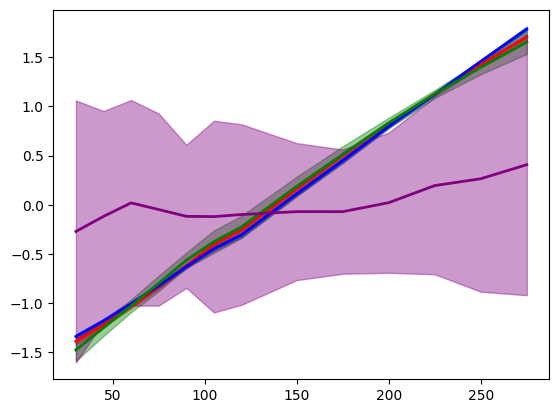

In [12]:
x_train = np.array(Tlist[0:nT])
I1=I[0:nT,:,:]
masked    = Mask_Zeros(I1,'any_zeros')
threshold = Threshold_Background(masked, None,'None')
print(masked.data_nonzero.shape)
print(threshold.data_thresholded.shape)

data_post_thresh =threshold.data_thresholded    # data.shape= (num_T, num_data)
data_post_thresh_no_mean = (data_post_thresh-np.mean(data_post_thresh,axis=0))/np.std(data_post_thresh,axis=0) #threshold.Rescale_traj(data_post_thresh)
y_train=data_post_thresh_no_mean.transpose() 

print('Data shape',y_train.shape)


num_clusters = 4
clusterGMM = GMM(y_train,num_clusters)
clusterGMM.RunEM()
print('Num per cluster',clusterGMM.num_per_cluster)
cluster_assignments = clusterGMM.cluster_assignments
clusterGMM.Plot_Cluster_Results_traj(x_train)



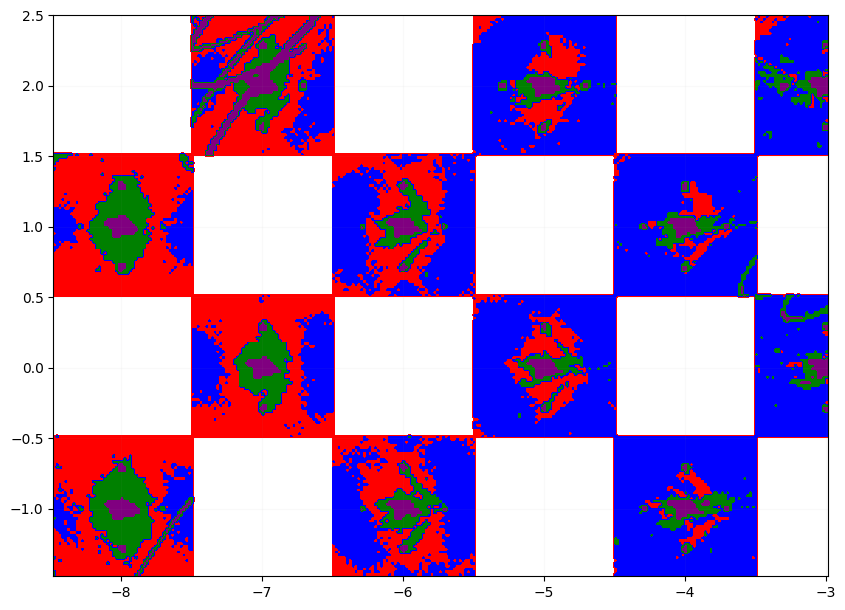

In [13]:
import matplotlib.pyplot as plt
from matplotlib import colors

plotting_slice = np.zeros(threshold.thresholded.shape)
for k in range(num_clusters):
    cluster_mask = (cluster_assignments == k)
    cluster_ind  = threshold.ind_thresholded[cluster_mask]
    plotting_slice[cluster_ind[:,0],cluster_ind[:,1]] = k+1


figsize=(10,10)
color_list = ['white', 'red', 'blue', 'green', 'purple', 'yellow', 'orange', 'pink']
cluster_cmap = colors.ListedColormap(color_list)
    
bounds = []
for i in range(len(color_list)+1):
    bounds.append(i-0.5)
norm = colors.BoundaryNorm(bounds,cluster_cmap.N)





fig=plt.figure(figsize=(10,10))
ax = fig.add_subplot(1, 1, 1)

plt.imshow(plotting_slice[426:625,1001-925:1001-650],origin='lower',extent=[Ql[1001-925], Ql[1001-650],Qh[426], Qh[625]],cmap=cluster_cmap,norm=norm)
plt.grid(color='#999999', linestyle='-', alpha=0.05)








In [14]:
Bad_Cluster=[3]                # 0: Red, 1: Blue, 2: Green, 3: purple, 4: yellow ...
Good_clusters = ~np.isin(cluster_assignments, Bad_Cluster)
Good_inds     = threshold.ind_thresholded[Good_clusters]


y_train= (threshold.data_thresholded[:,Good_clusters])
y_train = (y_train-np.mean(y_train,axis=0))/np.mean(y_train,axis=0)
#y_train = (y_train-np.mean(y_train,axis=0))/np.mean(y_train,axis=0)

y_train = y_train.transpose() 

print('Data shape',y_train.shape)

num_clusters = 2
clusterGMM_1 = GMM(y_train,num_clusters)
clusterGMM_1.RunEM()
print('Num per cluster',clusterGMM_1.num_per_cluster)
cluster_assignments_1 = clusterGMM_1.cluster_assignments
clusterGMM_1.Plot_Cluster_Results_traj(x_train)

Data shape (27051, 13)
Num per cluster [11638, 15413]


<module 'matplotlib.pyplot' from '/home/kmm537/dask_venv/lib/python3.8/site-packages/matplotlib/pyplot.py'>

### Plot results

In [15]:
import matplotlib.pyplot as plt
from matplotlib import colors



        
plotting_slice = threshold.thresholded.copy()

for k in range(num_clusters):
    cluster_mask = (cluster_assignments_1 == k)
    cluster_ind  = Good_inds[cluster_mask]
    plotting_slice[cluster_ind[:,0],cluster_ind[:,1]] = k+2


figsize=(10,10)
color_list = ['white','gainsboro', 'red', 'blue', 'green', 'purple', 'yellow', 'orange', 'pink']
cluster_cmap = colors.ListedColormap(color_list)
    
bounds = []
for i in range(len(color_list)+1):
    bounds.append(i-0.5)
norm = colors.BoundaryNorm(bounds,cluster_cmap.N)




fig=plt.figure(figsize=(20,20))
ax = fig.add_subplot(1, 1, 1)

plt.imshow(plotting_slice,origin='lower',cmap=cluster_cmap,norm=norm,extent=[Ql[0], Ql[-1],Qh[0], Qh[-1]])
plt.grid(color='#999999', linestyle='-', alpha=0.05)
plt.xticks(fontsize=30)
plt.yticks(fontsize=30)




(array([-10. ,  -7.5,  -5. ,  -2.5,   0. ,   2.5,   5. ,   7.5,  10. ]),
 [Text(0, -10.0, '−10.0'),
  Text(0, -7.5, '−7.5'),
  Text(0, -5.0, '−5.0'),
  Text(0, -2.5, '−2.5'),
  Text(0, 0.0, '0.0'),
  Text(0, 2.5, '2.5'),
  Text(0, 5.0, '5.0'),
  Text(0, 7.5, '7.5'),
  Text(0, 10.0, '10.0')])

In [17]:
fig=plt.figure(figsize=(12,10))
ax = fig.add_subplot(1, 1, 1)

plt.imshow(plotting_slice[425:626,1001-925:1001-650],origin='lower',extent=[Ql[1001-925], Ql[1001-650],Qh[425], Qh[625]],cmap=cluster_cmap,norm=norm)
plt.grid(color='#999999', linestyle='-', alpha=0.05)
plt.xticks(fontsize=30)
plt.yticks(fontsize=30)
plt.ylabel("$H$ (r.l.u.)",size=45)
plt.xlabel("$L$ (r.l.u.)",size=45)
plt.yticks( fontsize=40)
plt.xticks( fontsize=40)

plt.yticks(np.arange(-1, 2.5, 1), fontsize=40)
plt.xticks(np.arange(-8, -2.5, 1), fontsize=40)

plt.title(r'$x$=2.9%',size=45)
#plt.savefig('2x0_K_avg_XTEC_d.png',dpi=600)
plt.savefig(r'Diffuse_xtec_2x9.svg',bbox_inches='tight',transparent='True')

